In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [21]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [22]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [23]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)
# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index()
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [24]:
# divide the data into k different folds
fold_ids = split_lsms_spatial(lsms_df, n_folds = n_folds, random_seed = spatial_cv_random_seed)

Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19


In [25]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id', 'n_households',           
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

# Between model
This model takes as input any variable that is static, that is the OSM variables, ESA Landcover variables and the WSF variables. Moreover, it takes the mean over all dynamic variables. The dynamic variables include Nightlights, NDVI, and NDWI_Gao as well as NDWI_McF. 

The idea is that the between model captures variation between clusters and thus the target variable for the between model is $\bar{w}_c = \frac{1}{T_c}\sum_t^{T_c} w_{c,t}$ 

In [26]:
# get a dataset that only varies at the cluster level
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_pca_vars + osm_road_vars

between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation + median_rgb_vars

### Target: Log per capita consumption

In [27]:
between_target_var = 'avg_log_mean_pc_cons_usd_2017'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

In [28]:
# run the bewtween training
between_cv_trainer_cons = rf.CrossValidator(cl_df_norm, 
                                            fold_ids, 
                                            between_target_var, 
                                            between_x_vars, 
                                            id_var = 'cluster_id', 
                                            random_seed = random_seed)
between_cv_trainer_cons.run_cv_training(min_samples_leaf = 5)
between_cv_trainer_cons.compute_overall_performance()

Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 183 seconds


{'train_r2': 0.8125820964690904,
 'train_mse': 0.061073477471344416,
 'val_r2': 0.4611228061439311,
 'val_mse': 0.1578139003621209}

### Target: Asset index

In [29]:
# get a dataset that only varies at the cluster level
between_target_var = 'avg_mean_asset_index_yeh'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

In [30]:
# run the bewtween training
between_cv_trainer_asset = rf.CrossValidator(cl_df_norm, 
                                             fold_ids,
                                             between_target_var, 
                                             between_x_vars, 
                                             id_var = 'cluster_id',
                                             random_seed = random_seed)
between_cv_trainer_asset.run_cv_training(min_samples_leaf = 5)
between_cv_trainer_asset.compute_overall_performance()

Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds


{'train_r2': 0.8299742661002685,
 'train_mse': 0.44129596487328987,
 'val_r2': 0.5077608939432775,
 'val_mse': 1.1963032601070076}

# Within model
This goal of this model is to predict the deviations from the cluster mean for each year. I.e. the model should capture variation within each cluster. To do so, the target variable is $\tilde{w}_{ct} = w_{ct} - \bar{w}_{c}$. 

For cluster $c$ in time period $t$, the feature vector is defined as $\tilde{\boldsymbol{x}}_{ct} = \boldsymbol{x}_{ct} - \bar{\boldsymbol{x}}_{c}, where~\bar{\boldsymbol{x}}_{c} \in \mathbb{R}^{k\times1}$. 

To predict $\tilde{w}_{ct}$, I rely on $\tilde{\boldsymbol{x}}_{ct}$. This allows me to interpret the performance metric as the within R2, i.e. the share of the variance the model captures within clusters. 


(this does not help at all, thus disregard)...
To augment the number of training observations, I train the model on deltas, rather than on the demeaned variables. This substantially increases the number of training observations and covers a wider range of differences, making the training dataset more versatile and robust. Ideally, this helps to learn from a wider range of differences and thus increases the out-of-sample when predicting $\tilde{\boldsymbol{w}}_{ct}$.

In [31]:
dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation + dyn_rgb_vars

### Target variable: Consumption

In [32]:
# define the within variables
within_target_var = 'log_mean_pc_cons_usd_2017'
within_df = df[['cluster_id','unique_id', within_target_var] + within_x_vars]

# demean the data and standardise the variables
demeaned_df = demean_df(within_df)
demeaned_df_norm = standardise_df(demeaned_df, exclude_cols = [within_target_var])

In [33]:
# run the within training
within_cv_trainer_cons = rf.CrossValidator(demeaned_df_norm, fold_ids, within_target_var, within_x_vars, id_var = 'unique_id', random_seed = random_seed)
within_cv_trainer_cons.run_cv_training(min_samples_leaf = 5)
within_cv_trainer_cons.compute_overall_performance()

Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 593 seconds


{'train_r2': 0.5623933210528064,
 'train_mse': 0.024518040181107457,
 'val_r2': 0.006200384214239962,
 'val_mse': 0.05563720884284769}

### Target Variable: Asset Index

In [34]:
# define the within variables
within_target_var = 'mean_asset_index_yeh'
within_df = df[['cluster_id','unique_id', within_target_var] + within_x_vars]

# demean the data and standardise the variables
demeaned_df = demean_df(within_df)
demeaned_df_norm = standardise_df(demeaned_df, exclude_cols = [within_target_var])

In [35]:
# run the within training
within_cv_trainer_asset = rf.CrossValidator(demeaned_df_norm, fold_ids, within_target_var, within_x_vars, id_var = 'unique_id', random_seed = random_seed)
within_cv_trainer_asset.run_cv_training(min_samples_leaf = 5)
within_cv_trainer_asset.compute_overall_performance()

Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 493 seconds


{'train_r2': 0.572409041058777,
 'train_mse': 0.032343498826529864,
 'val_r2': 0.0377167798294975,
 'val_mse': 0.07311895737601135}

# Combined model
This model combines the within and between model to make the overall predictions on the validation samples

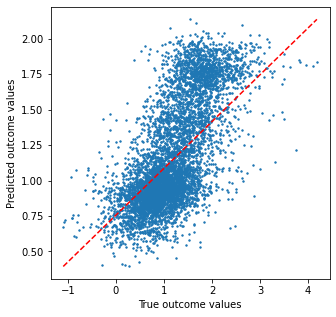

& 0.4611 & 0.0062 & 0.3852


In [36]:
combined_model_cons = CombinedModel(lsms_df, between_cv_trainer_cons, within_cv_trainer_cons)
combined_model_cons.evaluate()
combined_model_cons.plot_true_vs_preds()
combined_model_cons.print_tex(metric = 'r2')

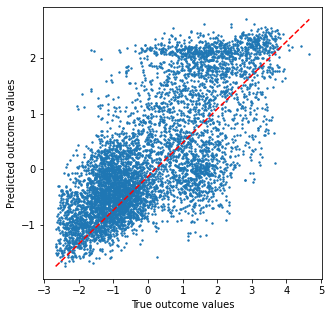

& 0.5078 & 0.0376 & 0.4950


In [37]:
combined_model_asset = CombinedModel(lsms_df, between_cv_trainer_asset, within_cv_trainer_asset)
combined_model_asset.evaluate()
combined_model_asset.plot_true_vs_preds()
combined_model_asset.print_tex(metric = 'r2')

In [38]:
# save the predictions to plot the data
#preds.to_csv("../results/predictions/baseline_preds.csv", index = False)

# Delta model

In [39]:
# # define the within variables
# within_x_vars = rs_dyn_vars + ['precipitation']
# within_target_var = 'log_mean_pc_cons_usd_2017'
# within_df = df[['cluster_id','unique_id', within_target_var] + within_x_vars]

In [40]:
# demeaned_df = demean(within_df)
# delta_df = make_delta_df(within_df)

# # combine the delta df, with the demeaned df
# demeaned_df = demeaned_df.rename(columns = {'unique_id': 'delta_id'})
# delta_df = pd.concat([delta_df, demeaned_df]).reset_index(drop = True)
# delta_df_norm = standardise_df(delta_df)

In [41]:
# # run the within training
# within_cv_trainer = rf.CrossValidator(delta_df_norm, fold_ids, within_target_var, within_x_vars, id_var = 'delta_id', random_seed = random_seed)
# within_cv_trainer.run_cv_training(min_samples_leaf = 15)
# within_cv_trainer.compute_overall_performance()

In [42]:
# # evaluate the model on the demeaned df
# within_evaluator = rf.CV_Evaluator(standardise_df(demeaned_df), fold_ids, within_cv_trainer, id_var = 'delta_id')
# within_evaluator.evaluate()
# within_evaluator.compute_overall_performance()